In [1]:
import numpy as np
import pandas as pd
from datetime import datetime

import warnings

import seaborn as sns
import matplotlib.pyplot as plt

import yfinance as yf
import numpy as np
import pandas as pd
from datetime import datetime

import warnings
from arch.compat.numba import jit
warnings.filterwarnings('ignore')

import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use("bmh")
plt.rcParams['font.family'] = 'DejaVu Sans'

import scipy.stats as ss
from arch import arch_model
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.style.use("bmh")

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf

In [2]:
def raw_adj_close_prices(ticker: str, date_from: str, date_to: str):
    prices = yf.download(ticker, date_from, date_to)
    prices.index = prices.index.to_period(freq='d')
    return prices['Adj Close']

In [3]:
def raw_adj_close_log_returns(prices: pd.Series):
    return np.log(prices).diff().dropna()

In [4]:
def beta(market: pd.Series, single_stock: pd.Series, lag: int = 252):
    if True:
        return 0 # fixme
    return market.cov(single_stock, lag) / market.std(ddof=lag)

In [5]:
@jit
def arch_filtered_series(returns: pd.Series,
                         dist: str = 'Normal',
                         mean: str = 'HARX',
                         vol: str = 'Garch',
                         lag: int = 200,
                         p: int = 1,
                         o: int = 0,
                         q: int = 1,
                         forecast_horizon: int = 30):
    scaling_const = 10.0 / returns.std()

    model = arch_model(scaling_const * returns,
                       mean=mean, lags=lag, # mean = Constant, ARX, HARX + the number of lags
                       vol=vol, p=p, o=o, q=q, # vol = Garch, EGARCH, HARCH + the number of lags
                       dist=dist) # dist = Normal, t, skewstudent, ged

    res = model.fit(update_freq=0, disp='off')
    stand_residuals = res.resid / res.conditional_volatility
    forecast = res.forecast(horizon=forecast_horizon)
    means = pd.Series(forecast.mean.tail(1).to_numpy()[0])
    vars = pd.Series(forecast.variance.tail(1).to_numpy()[0])
    return stand_residuals, means, vars

In [6]:
DATE_FROM = '2015-01-01'
DATE_TO = '2017-12-31'
tickers = ['TSLA', 'AAPL', 'IBM', 'AMZN', 'MMM',
           'ABMD', 'ACN', 'APD', 'GOOGL', 'BLK']

In [7]:
BETA_LAG = 252
GARCH_LAG = 200
CORRELATION_MATRIX_LAG = 200
GARCH_REFIT_DELAY_DAYS = 30

In [9]:
spy_p = raw_adj_close_prices('SPY', DATE_FROM, DATE_TO)

raw_prices = []
for i in range(0, len(tickers)):
    raw_prices.append(raw_adj_close_prices(tickers[i], DATE_FROM, DATE_TO))


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


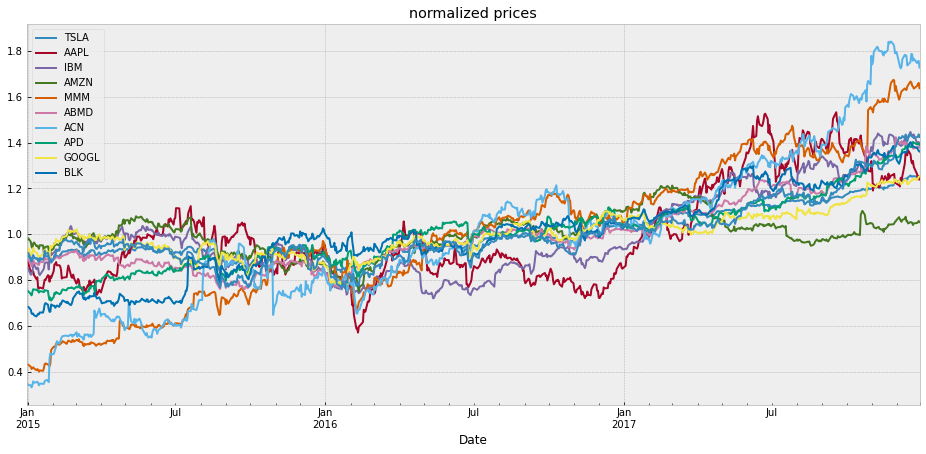

In [11]:
plt.figure(figsize=(16,7))
(spy_p / spy_p.mean()).plot()
for data in raw_prices:
    (data / data.mean()).plot()
plt.title("normalized prices")
plt.legend(tickers)
plt.show()

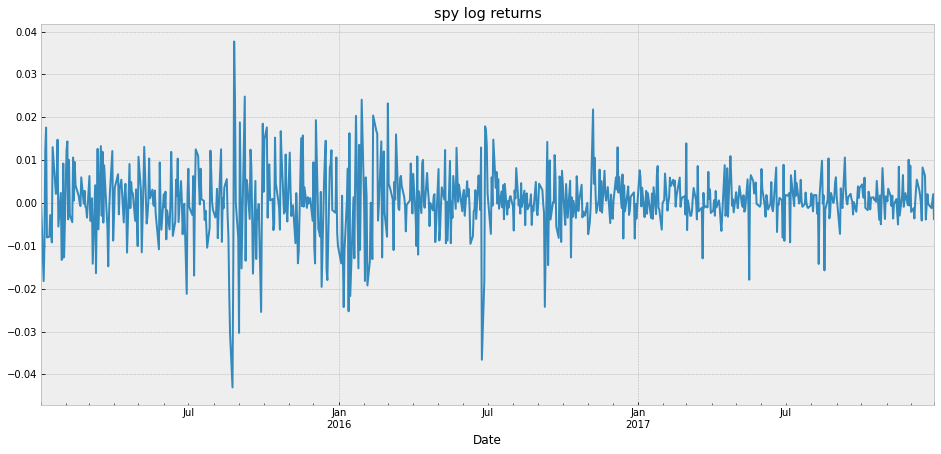

In [12]:
spy = raw_adj_close_log_returns(spy_p)
plt.figure(figsize=(16,7))
spy.plot()
plt.title("spy log returns")
plt.show()

/home/krm/PycharmProjects/pythonProject/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


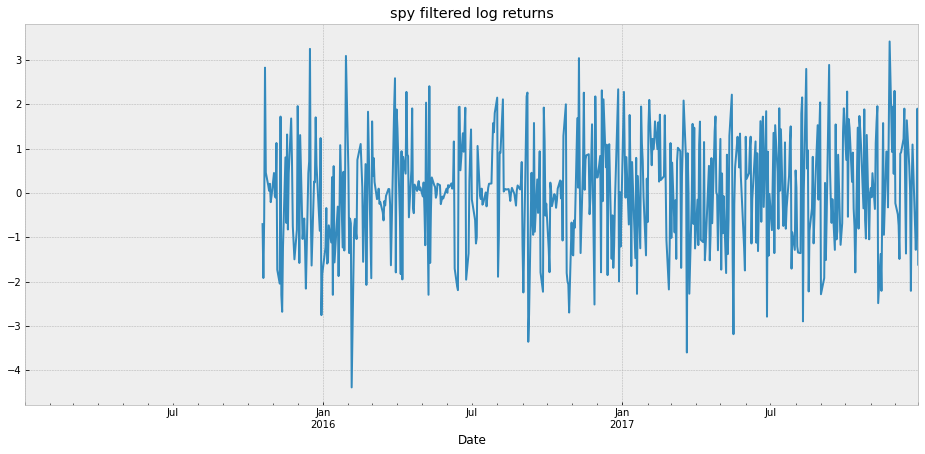

In [13]:
spyf, spy_means, spy_vars = arch_filtered_series(spy)
plt.figure(figsize=(16,7))
spyf.plot()
plt.title("spy filtered log returns")
plt.show()

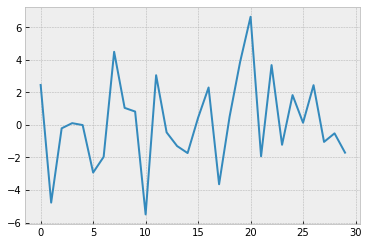

In [14]:
spy_means.plot()
plt.show()

<Figure size 1152x504 with 0 Axes>

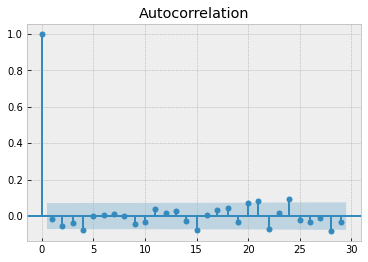

In [15]:
plt.figure(figsize=(16,7))
plot_acf(spy)
plt.show()


<Figure size 1152x504 with 0 Axes>

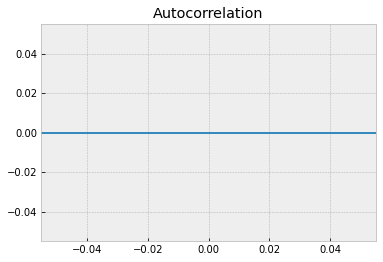

In [16]:
plt.figure(figsize=(16,7))
plot_acf(spyf)
plt.show()

In [17]:
res = spy_p.values
result = adfuller(res)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))
    
res = spy.values
result = adfuller(res)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))
    
res = spyf.dropna().values
result = adfuller(res)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: 0.354182
p-value: 0.979698
Critical Values:
	1%: -3.439
	5%: -2.865
	10%: -2.569
ADF Statistic: -15.784424
p-value: 0.000000
Critical Values:
	1%: -3.439
	5%: -2.865
	10%: -2.569
ADF Statistic: -23.149132
p-value: 0.000000
Critical Values:
	1%: -3.442
	5%: -2.867
	10%: -2.570


In [ ]:
# betas = {}
# for ticker, data in raw_prices.items():
#     betas[ticker] = beta(spy_p, data)
#
# betas

In [ ]:
# net_market = raw_adj_close_log_returns(raw_prices['TSLA']) - spy * betas['TSLA']
# plt.figure(figsize=(16,7))
# net_market.plot()
# plt.show()

In [ ]:
# teslaf, _ = arch_filtered_series(net_market)
# plt.figure(figsize=(16,7))
# teslaf.plot()
# plt.title("tsla filtered log returns")
# plt.show()

In [ ]:
# res = net_market.values
# result = adfuller(res)
# print('ADF Statistic: %f' % result[0])
# print('p-value: %f' % result[1])
# print('Critical Values:')
# for key, value in result[4].items():
#     print('\t%s: %.3f' % (key, value))
#
# res = teslaf.dropna().values
# result = adfuller(res)
# print('ADF Statistic: %f' % result[0])
# print('p-value: %f' % result[1])
# print('Critical Values:')
# for key, value in result[4].items():
#     print('\t%s: %.3f' % (key, value))
#

In [19]:
series, means, vars = arch_filtered_series(spy)

/home/krm/PycharmProjects/pythonProject/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


In [21]:
mkt_returns = []
for i in range(0, len(raw_prices)):
    ticker = tickers[i]
    data = raw_prices[i]
    mkt_returns.append(raw_adj_close_log_returns(data))

betas = []
for i in range(0, len(mkt_returns)):
    ticker = tickers[i]
    data = mkt_returns[i]
    betas.append(beta(spy, data))

net_market_returns = []
for i in range(0, len(mkt_returns)):
    ticker = tickers[i]
    data = mkt_returns[i]
    net_market_returns.append(data - spy * betas[i])

In [22]:
net_market_returns_f = []
means = []
vars = []
for i in range(0, len(net_market_returns)):
    ticker = tickers[i]
    net_rets = net_market_returns[i]
    fltr_res, fcst_means, fcst_vars = arch_filtered_series(net_rets)
    net_market_returns_f.append(fltr_res)
    means.append(fcst_means.dropna())
    vars.append(fcst_vars.dropna())

net_market_returns_f


/home/krm/PycharmProjects/pythonProject/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/krm/PycharmProjects/pythonProject/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/krm/PycharmProjects/pythonProject/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/krm/PycharmProjects/pythonProject/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp 

[Date
 2015-01-02         NaN
 2015-01-05         NaN
 2015-01-06         NaN
 2015-01-07         NaN
 2015-01-08         NaN
                 ...   
 2017-12-22   -1.400447
 2017-12-26   -0.617690
 2017-12-27    0.428372
 2017-12-28    1.802447
 2017-12-29   -0.417045
 Freq: D, Length: 755, dtype: float64,
 Date
 2015-01-02         NaN
 2015-01-05         NaN
 2015-01-06         NaN
 2015-01-07         NaN
 2015-01-08         NaN
                 ...   
 2017-12-22   -1.271196
 2017-12-26   -1.271624
 2017-12-27    1.117057
 2017-12-28    0.415068
 2017-12-29   -0.923459
 Freq: D, Length: 755, dtype: float64,
 Date
 2015-01-02         NaN
 2015-01-05         NaN
 2015-01-06         NaN
 2015-01-07         NaN
 2015-01-08         NaN
                 ...   
 2017-12-22    0.042414
 2017-12-26    0.071192
 2017-12-27   -0.431635
 2017-12-28   -0.426105
 2017-12-29   -0.673036
 Freq: D, Length: 755, dtype: float64,
 Date
 2015-01-02         NaN
 2015-01-05         NaN
 2015-01-06        

In [24]:
returns = {}
for i in range(0, len(tickers)):
    returns[tickers[i]] = net_market_returns_f[i].dropna()

data = pd.DataFrame(returns, columns=tickers)

In [25]:
data

,TSLA,AAPL,IBM,AMZN,MMM,ABMD,ACN,APD,GOOGL,BLK
Date,,,,,,,,,,
2015-10-19,-1.100618,-0.403606,-0.485564,2.569175,-0.482926,0.659505,-0.350916,-1.546767,1.236800,-0.735755
2015-10-20,-3.038211,1.713722,-4.631988,0.135961,1.331827,-0.751435,-0.395147,-0.265373,-1.127022,-1.280025
2015-10-21,-0.577030,-1.680733,0.587160,0.815747,1.208301,-2.060851,-1.063280,-0.365815,-1.677984,-1.380620
2015-10-22,0.758246,1.720788,1.071438,0.816001,2.637991,-2.466858,3.061537,1.277760,0.745737,1.714084
2015-10-23,0.486964,1.473404,-0.140297,1.950616,0.685301,0.707733,1.244310,-0.692379,1.333691,0.850783
...,...,...,...,...,...,...,...,...,...,...
2017-12-22,-1.400447,-1.271196,0.042414,-1.330102,-1.145276,-1.577803,-0.247035,-0.629087,-1.582613,0.467467
2017-12-26,-0.617690,-1.271624,0.071192,2.049192,-0.881996,-0.304017,-1.762913,-1.278083,0.011605,-0.580748
2017-12-27,0.428372,1.117057,-0.431635,-0.837140,0.247604,-1.670798,0.398319,0.470067,-0.229283,1.263928


In [26]:
corr_matrix = data.corr(min_periods=200)
corr_matrix

,TSLA,AAPL,IBM,AMZN,MMM,ABMD,ACN,APD,GOOGL,BLK
TSLA,1.000000,0.086383,0.104883,0.134975,0.012399,0.116068,0.161781,0.081482,0.080881,0.087795
AAPL,0.086383,1.000000,0.085712,0.183180,0.140335,0.211524,0.130574,0.129804,0.253925,0.137240
IBM,0.104883,0.085712,1.000000,0.027318,0.200706,0.040307,0.262195,0.170275,0.073436,0.210439
AMZN,0.134975,0.183180,0.027318,1.000000,0.059004,0.063422,0.177599,0.078468,0.258528,0.066069
MMM,0.012399,0.140335,0.200706,0.059004,1.000000,0.141491,0.196611,0.236760,0.172466,0.205785
ABMD,0.116068,0.211524,0.040307,0.063422,0.141491,1.000000,0.132122,0.050926,0.112201,0.119938
ACN,0.161781,0.130574,0.262195,0.177599,0.196611,0.132122,1.000000,0.262165,0.281658,0.275918
APD,0.081482,0.129804,0.170275,0.078468,0.236760,0.050926,0.262165,1.000000,0.147497,0.194793
GOOGL,0.080881,0.253925,0.073436,0.258528,0.172466,0.112201,0.281658,0.147497,1.000000,0.135657
BLK,0.087795,0.137240,0.210439,0.066069,0.205785,0.119938,0.275918,0.194793,0.135657,1.000000


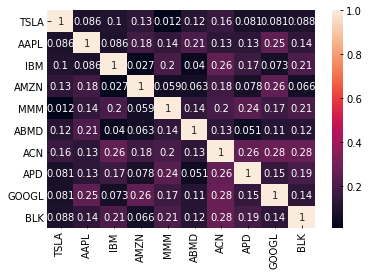

In [27]:
sns.heatmap(corr_matrix, annot=True)
plt.show()

In [28]:
corr_matrix.iloc[0]


TSLA     1.000000
AAPL     0.086383
IBM      0.104883
AMZN     0.134975
MMM      0.012399
ABMD     0.116068
ACN      0.161781
APD      0.081482
GOOGL    0.080881
BLK      0.087795
Name: TSLA, dtype: float64

In [29]:
def remove_row_and_column(matrix, index: int):
    tmp = np.delete(matrix, (index), axis=0)
    return np.delete(tmp, (index), axis=1)

In [ ]:
mus = [] ### fixme: move to indicies
for i in range(0, len(tickers)):
    r_j_j = remove_row_and_column(corr_matrix, i)
    inv_r_j_j = np.linalg.inv(r_j_j)
    mu_j = np.delete(means, i)
    sigma_j = np.delete(vars, i)
    v = (real_returns - mu_j) / sigma_j
    mus.append(means[i][0] + vars[i][0] * corr_matrix[i].dot(inv_r_j_j).dot(v))

In [30]:
def alpha(mu, real_return):
    return 2 * mu - real_return